In [2]:
import numpy
import numpy as np
from qutip import *

Etat initial: Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1.04811889 0.        ]
 [0.         0.95188111]]


C:\Users\corei5\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mean square error: 1.267281670458265


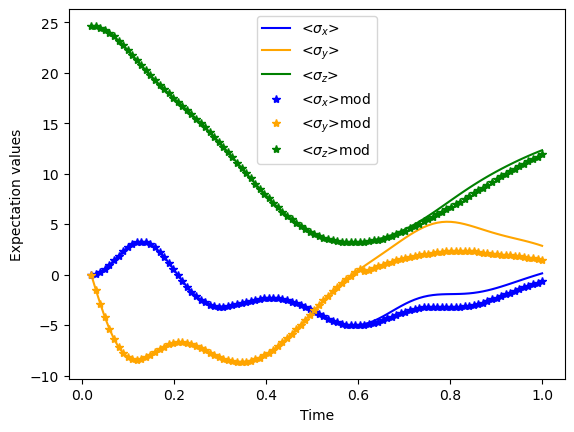

In [7]:
#Paramètres du systeme physique
N=3 #Taille du réseau
T=100
gamma = 0.4
#OPÉRATEURS DE SPIN
# - Définition des opérateurs de Pauli
sx = sigmax()
sy = sigmay()
sz = sigmaz()
n = 0.5*(1+sz)

id_= tensor([qeye(2)]*(N*N-1)) #identity operators in the Hibert space


sx = [[tensor(id_, sigmax())]*N]*N     #Spin observables in the bath in x direction
sx[1][1] = tensor(sigmax(), id_)       #System spin operator in x direction
sx_list = sx

sy = [[tensor(id_, sigmay())]*N]*N     #Spin observables in the bath in y direction
sy[1][1] = tensor(sigmay(), id_)       #System spin operator in y direction
sy_list = sy

sz = [[tensor(id_, sigmaz())]*N]*N     #Spin observables in the bath in y direction
sz[1][1] = tensor(sigmaz(), id_)       #System spin operator in z direction
sz_list = sz

n_B = [[tensor(id_, 0.5*(1 + sigmaz()))]*N]*N
n_B[1][1] = tensor(0.5*(1 + sigmaz()), id_)
n_list = n_B

#HAMILTONIEN DU SYSTEME (CONDITIONS AUX LIMITES OUVERTS)
def H2D_OBC(omega, V, alpha, delta):
    #
    #Hamiltonien d’interaction
    H_int = 0
    for i in range(N):
        for j in range(N):
            for ii in range(1,N):
                for jj in range(1,N):
                    if ii < jj:
                        H_int+= V/(abs(ii-jj)**alpha)*(n_list[i][j])*(n_list[(i+ii)%N][(j+jj)%N])
    #Hamiltonien libre
    H0_l = 0 #Hamiltonien du champ longitudinal
    H0_t = 0 #Hamiltonien du champ transversale
    for i in range(N):
        for j in range(N):
            H0_l += -delta*n_list[i][j]
            H0_t += omega*sx_list[i][j]
    H = H0_t + H0_l + H_int
    return(H)

# Etat initial du systeme
a = np.random.uniform(0.01,0.7)
hro0_S = Qobj([[1-a,0],[0,a]])
for i in range(100):
    x= np.random.uniform(0,0.7)
    y=np.random.uniform(0,0.7)
    z=np.random.uniform(0,0.7)
    hro0_S = Qobj([[1+z,complex(x,-y)],[complex(x,y),1-z]])
    hro0_S = Qobj([[1+z,0],[0,1-z]])
# print(hro0_S)
hro0 = tensor(hro0_S, id_)
print('Etat initial:',hro0_S)
#hro0 = tensor(Qobj([[0.52066722,0], [0, 0.59590664]]), qeye(2**(N-1)))

#List fo Lindblad oparators
L0 = [[np.sqrt(gamma)*(tensor(id_, 0.5*(1 + sigmaz())))]*N]*N
L0[1][1] = np.sqrt(gamma)*(tensor(0.5*(1 + sigmaz()), id_))
L = L0

H = H2D_OBC(omega=1, V=5, alpha=8, delta=2)
tlist = np.linspace(0.0, 1.0, 100)
result = mesolve(H, hro0, tlist, L, [sx_list[1][1], sy_list[1][1], sz_list[1][1]] )


# Donnees d'entrees
tlistx = np.linspace(0, 1, 100)
resultx = mesolve(H, hro0, tlistx, L, [sx_list[1][1], sy_list[1][1], sz_list[1][1]], args=None, options=None, progress_bar=None, _safe_mode=True)
X0 = resultx.expect[0]
X1 = resultx.expect[1] 
X2 = resultx.expect[2]
#print(X0.shape)

# Etiquettes
tlisty = np.linspace(0+0.02, 1, 100)
resulty = mesolve(H, hro0, tlisty, L, [sx_list[1][1], sy_list[1][1], sz_list[1][1]], args=None, options=None, progress_bar=None, _safe_mode=True)
Y0 = resulty.expect[0]
Y1 = resulty.expect[1]
Y2 = resulty.expect[2]

X = np.transpose([np.ones(100), X0, X1, X2])  #Ensemble des donnee d'entree de formation
Y = np.transpose([np.ones(100), Y0, Y1, Y2])  #Ensemble des etiquettes

from numpy.random import rand
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 40, train_size = 60, random_state = None, shuffle=False, stratify = None)

model = MLPRegressor(hidden_layer_sizes =(100,100,100,100), activation='relu', solver='adam', alpha = 0.1)

#Apprentissage du modele avec l'ensemble des donnees d'apprentissage
model.fit(X_train, Y_train)

#Evaluation de la performence du modele avec l'ensemble des donnees de test
Y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
print('mean square error:', mse)

#Valeux predicte pour chaque observable du systeme
Y_pred_X = Y_pred[:,1]
Y_pred_Y = Y_pred[:,2]
Y_pred_Z = Y_pred[:,3]


#Visualisation graphique des valeurs compratives
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
#Dynamique exacte
ax.plot(resulty.times, resultx.expect[0], label='<$\sigma_x$>', color='blue')
ax.plot(resulty.times, resultx.expect[1], label='<$\sigma_y$>', color='orange')
ax.plot(resulty.times, resultx.expect[2], label='<$\sigma_z$>', color='green')
#Apprentissage
ax.plot(resulty.times[0:60], X_train[:,1], linestyle='None', label='<$\sigma_x$>mod', color='blue', marker='*')
ax.plot(resulty.times[0:60], X_train[:,2], linestyle='None', label='<$\sigma_y$>mod', color='orange', marker='*')
ax.plot(resulty.times[0:60], X_train[:,3], linestyle='None', label='<$\sigma_z$>mod', color='green', marker='*')
#Extrapolation ou prediction
ax.plot(resulty.times[60:100], Y_pred_X, linestyle='None', color='blue', marker='*')
ax.plot(resulty.times[60:100], Y_pred_Y, linestyle='None', color='orange', marker='*')
ax.plot(resulty.times[60:100], Y_pred_Z, linestyle='None', color='green',marker='*')
ax.set_xlabel('Time')
ax.set_ylabel('Expectation values')
plt.legend()
plt.show()